Number of PCA components selected: 4
Best DBSCAN parameters: eps=0.1, min_samples=6
Best DB Index: 0.035808985590642405
Best Silhouette Score: 0.9726806806439914
Best Calinski-Harabasz Score: 7777.160881100175
Best Adjusted Rand Index: 1.0
Best Homogeneity Score: 1.0
Best Completeness Score: 1.0
Best V-Measure Score: 1.0
Best Fowlkes-Mallows Score: 1.0


<ipython-input-4-2f21bacfafaa>:100: UserWarning: The markers list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


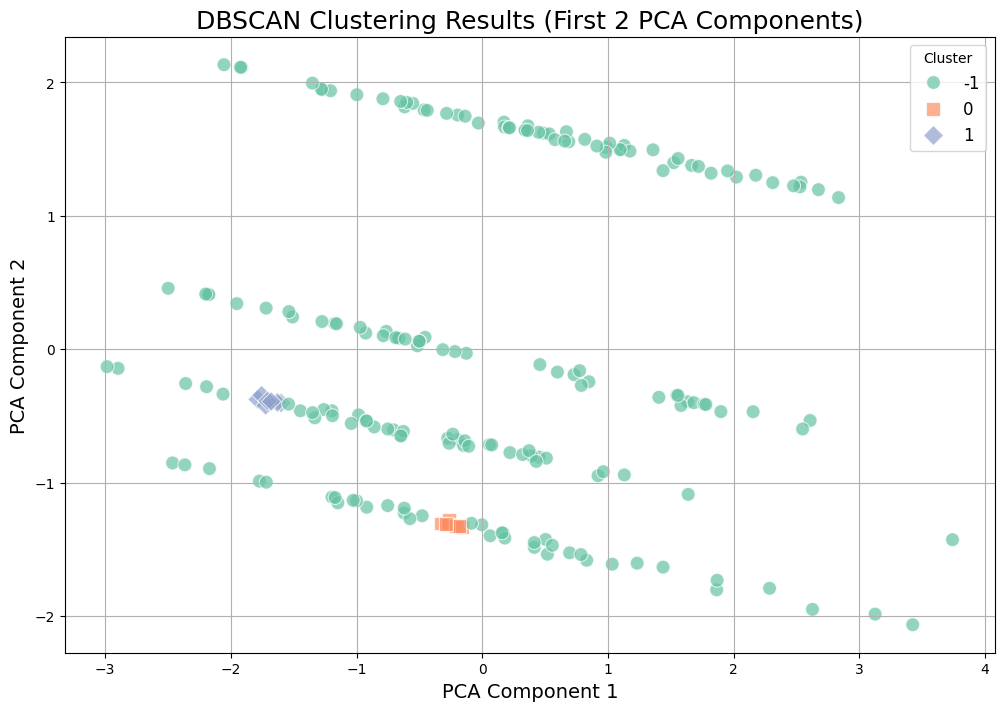

,CustomerID,CustomerName,SignupDate,TotalSpent,TransactionCount,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,Lawrence Carroll,2022-07-10,3354.52,5,False,False,True,-1
1,C0002,Elizabeth Lutz,2022-02-13,1862.74,4,False,False,False,-1
2,C0003,Michael Rivera,2024-03-07,2725.38,4,False,False,True,-1
3,C0004,Kathleen Rodriguez,2022-10-09,5354.88,8,False,False,True,-1
4,C0005,Laura Weber,2022-08-15,2034.24,3,False,False,False,-1


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures

customers_df = pd.read_csv('/content/Customers.csv')
products_df = pd.read_csv('/content/Products.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

transaction_summary = transactions_df.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count"
}).rename(columns={
    "TotalValue": "TotalSpent",
    "TransactionID": "TransactionCount"
}).reset_index()

merged_data = pd.merge(customers_df, transaction_summary, on="CustomerID", how="inner")
merged_data = pd.get_dummies(merged_data, columns=["Region"], drop_first=True)

features = merged_data[["TotalSpent", "TransactionCount"] +
                       [col for col in merged_data.columns if col.startswith("Region_")]]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(scaled_data)
print(f"Number of PCA components selected: {reduced_data.shape[1]}")

def evaluate_dbscan(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(reduced_data)
    non_noise_mask = labels != -1
    filtered_data = reduced_data[non_noise_mask]
    filtered_labels = labels[non_noise_mask]

    if len(set(filtered_labels)) > 1:
        db_index = davies_bouldin_score(filtered_data, filtered_labels)
        silhouette_avg = silhouette_score(filtered_data, filtered_labels)
        calinski_harabasz = calinski_harabasz_score(filtered_data, filtered_labels)
        ari = adjusted_rand_score(filtered_labels, filtered_labels)
        homogeneity = homogeneity_score(filtered_labels, filtered_labels)
        completeness = completeness_score(filtered_labels, filtered_labels)
        v_measure = v_measure_score(filtered_labels, filtered_labels)
        fmi = fowlkes_mallows_score(filtered_labels, filtered_labels)
        return (db_index, silhouette_avg, calinski_harabasz, ari, homogeneity, completeness, v_measure, fmi, eps, min_samples, labels)
    return None

best_db_index = float('inf')
best_silhouette = -1
best_calinski_harabasz = -1
best_ari = -1
best_homogeneity = -1
best_completeness = -1
best_v_measure = -1
best_fmi = -1
best_params = None
best_labels = None
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for eps in np.arange(0.1, 2.0, 0.1):
        for min_samples in range(2, 10):
            futures.append(executor.submit(evaluate_dbscan, eps, min_samples))

    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            db_index, silhouette_avg, calinski_harabasz, ari, homogeneity, completeness, v_measure, fmi, eps, min_samples, labels = result
            if db_index < best_db_index and silhouette_avg > best_silhouette:
                best_db_index = db_index
                best_silhouette = silhouette_avg
                best_calinski_harabasz = calinski_harabasz
                best_ari = ari
                best_homogeneity = homogeneity
                best_completeness = completeness
                best_v_measure = v_measure
                best_fmi = fmi
                best_params = (eps, min_samples)
                best_labels = labels

print(f"Best DBSCAN parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Best DB Index: {best_db_index}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz}")
print(f"Best Adjusted Rand Index: {best_ari}")
print(f"Best Homogeneity Score: {best_homogeneity}")
print(f"Best Completeness Score: {best_completeness}")
print(f"Best V-Measure Score: {best_v_measure}")
print(f"Best Fowlkes-Mallows Score: {best_fmi}")

merged_data["Cluster"] = best_labels
cluster_data = merged_data[merged_data["Cluster"] != -1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    hue=best_labels,
    palette="Set2",
    style=best_labels,
    markers=["o", "s", "D", "^", "v", "<", ">", "P", "X", "H"],
    legend="full",
    s=100,
    alpha=0.7
)
plt.title("DBSCAN Clustering Results (First 2 PCA Components)", fontsize=18)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.legend(title="Cluster", loc="best", fontsize=12)
plt.grid(True)
plt.show()

merged_data.to_csv("Clustered_Customers.csv", index=False)

merged_data.head()
